## 0. Importing PyTorch and setting up device agnostic code

In [1]:
# Imports
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm

# Import PyTorch
import torch
import torch.nn as nn

# Import torchvision
from torch.utils.data import DataLoader, Dataset
import torchvision
from torchvision.transforms import transforms

# Instal torchinfo
!pip install torchinfo
from torchinfo import summary

In [28]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [76]:
# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !mv pytorch-deep-learning/helper_functions.py . # get the helper_functions.py script
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves

[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 4393, done.
remote: Counting objects: 100% (1534/1534), done.
remote: Compressing objects: 100% (133/133), done.
remote: Total 4393 (delta 1457), reused 1401 (delta 1401), pack-reused 2859 (from 2)
Receiving objects: 100% (4393/4393), 650.71 MiB | 16.26 MiB/s, done.
Resolving deltas: 100% (2659/2659), done.
Updating files: 100% (248/248), done.


## 1. Get Data

The data we're using if from Kaggle's dog breed identification competition. It consist of a collection of 10000+ lablled images of 120 different dog breeds.

https://www.kaggle.com/c/dog-breed-identification/data

In [2]:
!pip install kaggle

In [3]:
from google.colab import userdata
import os
os.environ["KAGGLE_KEY"] = userdata.get("KAGGLE_KEY")
os.environ["KAGGLE_USERNAME"] = userdata.get("KAGGLE_USERNAME")

In [4]:
# Download and unzip the data
!kaggle competitions download -c dog-breed-identification
!unzip dog-breed-identification

Streaming output truncated to the last 5000 lines.
  inflating: train/83bc62b0fffa99a9c94ba0b67a5f7395.jpg  
  inflating: train/83bcff6b55ee179a7c123fa6103c377a.jpg  
  inflating: train/83be6d622ab74a5e7e08b53eb8fd566a.jpg  
  inflating: train/83c2d7419b0429b9fe953bc1b6cddbec.jpg  
  inflating: train/83cf7d7cd2a759a93e2ffd95bea9c6fb.jpg  
  inflating: train/83d405858f0931722ef21e8ac0adee4d.jpg  
  inflating: train/83d4125a4c3c7dc5956563276cb1cd74.jpg  
  inflating: train/83f0bb565b2186dbcc6a9d009cb26ff2.jpg  
  inflating: train/83fad0718581a696132c96c166472627.jpg  
  inflating: train/83fbbcc9a612e3f712b1ba199da61f20.jpg  
  inflating: train/8403d8936430c2f05ab7d74d23c2c0cb.jpg  
  inflating: train/8406d837b2d7fac1c3cd621abb4c4f9e.jpg  
  inflating: train/840b67d26e5e43f8eb6430f62d4ba1ac.jpg  
  inflating: train/840db91ba4600148f3dcb06ec419b421.jpg  
  inflating: train/840dbad5a691c22611d85b2488bf4cbb.jpg  
  inflating: train/8410ced9ebc1759a7ebce5c42bfb5222.jpg  
  inflating: train/84

### 1.1 Inspect data and get it ready

In [5]:
# Check out the labels
import pandas as pd
labels_csv = pd.read_csv("/content/labels.csv")
labels_csv[:10]

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever
5,002211c81b498ef88e1b40b9abf84e1d,bedlington_terrier
6,00290d3e1fdd27226ba27a8ce248ce85,bedlington_terrier
7,002a283a315af96eaea0e28e7163b21b,borzoi
8,003df8b8a8b05244b1d920bb6cf451f9,basenji
9,0042188c895a2f14ef64a918ed9c7b64,scottish_deerhound


In [6]:
# See how many values of each breed we have
labels_csv["breed"].value_counts()

,count
breed,
scottish_deerhound,126
maltese_dog,117
afghan_hound,116
entlebucher,115
bernese_mountain_dog,114
...,...
golden_retriever,67
komondor,67
brabancon_griffon,67


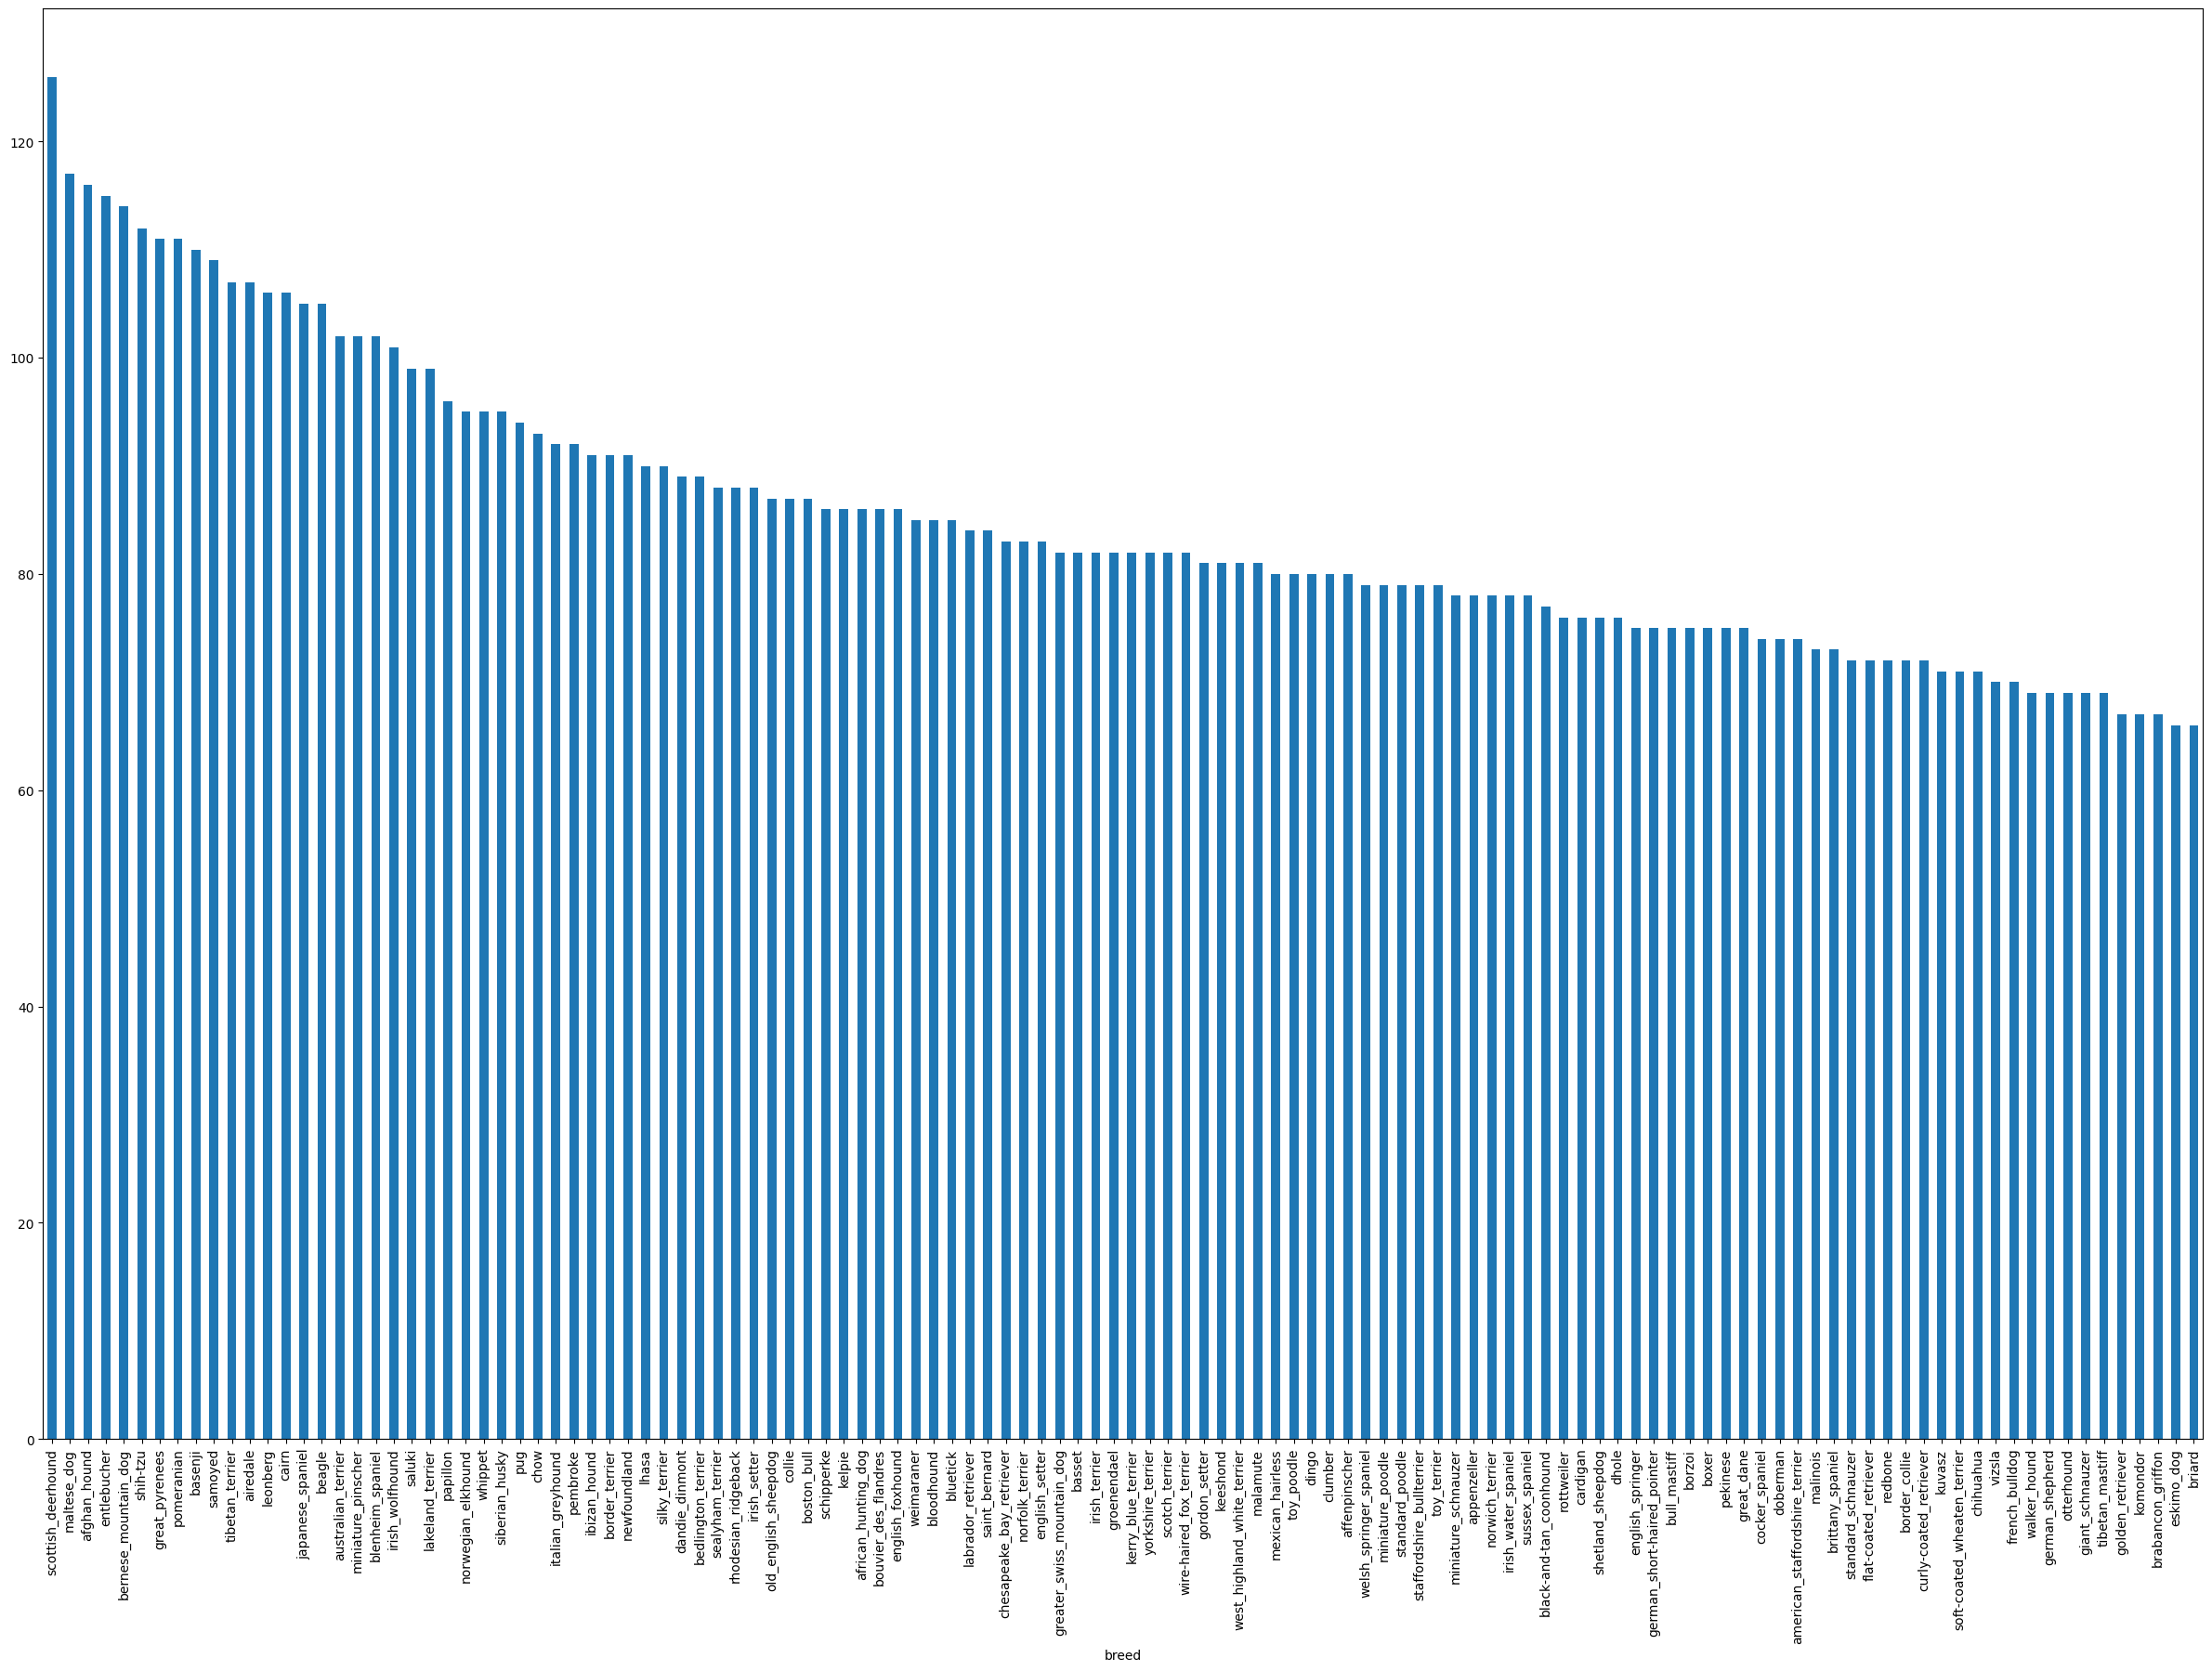

In [7]:
# Visualize it in a graphic
labels_csv["breed"].value_counts().plot.bar(figsize=(30,20));

In [8]:
# Tranform our labels into LabelEncoders
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
labels_csv["label_encoder"] = le.fit_transform(labels_csv["breed"])
labels_csv["label_encoder"]

,label_encoder
0,19
1,37
2,85
3,15
4,49
...,...
10217,18
10218,35
10219,3
10220,75


In [9]:
class_names = le.classes_
class_names[:5],
print(f"There are {len(class_names)} different class names")

There are 120 different class names


In [10]:
# Split the data into training and validation
from sklearn.model_selection import train_test_split

train_df, val_df = train_test_split(labels_csv,
                                    test_size = 0.2,
                                    stratify = labels_csv["label_encoder"],
                                    random_state = 42)
len(train_df), len(val_df)

(8177, 2045)

### 1.2 Create Custom PyTorch Dataset

In [11]:
# Create dataset
class DogVisionDataset(Dataset):
  """
  Arguments:
    dataframe (pd.DataFrame): DataFrame with image IDs and labels
    img_dir(str): directory to the images
    transform (callable, optional): Optional transform to be applied on a sample.
  """
  def __init__(self, dataframe:pd.DataFrame,
               img_dir: str,
               transform = None):
    self.dataframe = dataframe
    self.img_dir = img_dir
    self.transform = transform

  def __len__(self):
    return len(self.dataframe)

  def __getitem__(self, idx):
    if torch.is_tensor(idx):
        idx = idx.tolist()

    img_path = os.path.join(self.img_dir, self.dataframe.iloc[idx,0] + ".jpg")
    img = Image.open(img_path).convert("RGB")

    label = self.dataframe.iloc[idx,2]
    label = torch.tensor(label).long()

    if self.transform:
        img = self.transform(img)


    return img, label

In [12]:
# Create train and test directories
train_dir = "/content/train"
test_dir = "/content/test"

## 2. Start modeling and training

### 2.1 Starting with ResNet-50

In [ ]:
# Setup model with pretrained weights
weights = torchvision.models.ResNet50_Weights.DEFAULT
model_res50 = torchvision.models.resnet50(weights=weights)

In [ ]:
# Create transforms with autotransforms from the model weights
from torchvision import transforms

auto_transforms_res50 = weights.transforms()
auto_transforms_res50

ImageClassification(
    crop_size=[224]
    resize_size=[232]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [ ]:
# Create datasets
train_dataset = DogVisionDataset(dataframe=train_df,
                                 img_dir = train_dir,
                                 transform = auto_transforms_res50)

val_dataset = DogVisionDataset(dataframe = val_df,
                               img_dir = train_dir,
                               transform = auto_transforms_res50)

In [ ]:
# Create DataLoaders
from torch.utils.data import DataLoader
BATCH_SIZE = 32
NUM_WORKERS = 2

train_dataloader = DataLoader(train_dataset,
                              batch_size = BATCH_SIZE,
                              shuffle = True,
                              num_workers = NUM_WORKERS)

val_dataloader = DataLoader(val_dataset,
                            batch_size = BATCH_SIZE,
                            shuffle = False,
                            num_workers = NUM_WORKERS)

In [ ]:
#  Get a summary of our model
from torchinfo import summary

summary(model=model_res50,
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape"
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
ResNet (ResNet)                          [32, 3, 224, 224]    [32, 1000]           --                   True
├─Conv2d (conv1)                         [32, 3, 224, 224]    [32, 64, 112, 112]   9,408                True
├─BatchNorm2d (bn1)                      [32, 64, 112, 112]   [32, 64, 112, 112]   128                  True
├─ReLU (relu)                            [32, 64, 112, 112]   [32, 64, 112, 112]   --                   --
├─MaxPool2d (maxpool)                    [32, 64, 112, 112]   [32, 64, 56, 56]     --                   --
├─Sequential (layer1)                    [32, 64, 56, 56]     [32, 256, 56, 56]    --                   True
│    └─Bottleneck (0)                    [32, 64, 56, 56]     [32, 256, 56, 56]    --                   True
│    │    └─Conv2d (conv1)               [32, 64, 56, 56]     [32, 64, 56, 56]     4,096                True
│    │    └─BatchN

In [ ]:
# Freeze all base layers
for param in model_res50.parameters():
  param.requires_grad = False

#model_res50.fc.requires_grad_(True)

# Change the classifier
model_res50.fc = nn.Linear(in_features=2048, out_features=len(class_names))
model_res50.fc.requires_grad_(True)

Linear(in_features=2048, out_features=120, bias=True)

In [ ]:
# # Do a summary *after* freezing the features and changing the output classifier layer
summary(model_res50,
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape" (batch_size, color_channels, height, width)
        verbose=0,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
ResNet (ResNet)                          [32, 3, 224, 224]    [32, 120]            --                   Partial
├─Conv2d (conv1)                         [32, 3, 224, 224]    [32, 64, 112, 112]   (9,408)              False
├─BatchNorm2d (bn1)                      [32, 64, 112, 112]   [32, 64, 112, 112]   (128)                False
├─ReLU (relu)                            [32, 64, 112, 112]   [32, 64, 112, 112]   --                   --
├─MaxPool2d (maxpool)                    [32, 64, 112, 112]   [32, 64, 56, 56]     --                   --
├─Sequential (layer1)                    [32, 64, 56, 56]     [32, 256, 56, 56]    --                   False
│    └─Bottleneck (0)                    [32, 64, 56, 56]     [32, 256, 56, 56]    --                   False
│    │    └─Conv2d (conv1)               [32, 64, 56, 56]     [32, 64, 56, 56]     (4,096)              False
│    │    

In [53]:
import torch
from tqdm.auto import tqdm
from typing import Dict, List, Tuple

# Define train step
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device: torch.device) -> Tuple[float, float]:
    model.train()
    train_loss, train_correct = 0, 0
    total_samples = 0

    for X, y in dataloader:
        X, y = X.to(device), y.to(device)

        optimizer.zero_grad()
        y_pred = model(X)
        loss = loss_fn(y_pred, y)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * X.size(0)  # multiply by batch size for correct averaging
        preds = y_pred.argmax(dim=1)
        train_correct += (preds == y).sum().item()
        total_samples += y.size(0)

    avg_loss = train_loss / total_samples
    avg_acc = train_correct / total_samples
    return avg_loss, avg_acc


# Define test step
def val_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device: torch.device) -> Tuple[float, float]:
    model.eval()
    val_loss, val_correct = 0, 0
    total_samples = 0

    with torch.inference_mode():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)

            y_pred = model(X)
            loss = loss_fn(y_pred, y)

            val_loss += loss.item() * X.size(0)
            preds = y_pred.argmax(dim=1)
            val_correct += (preds == y).sum().item()
            total_samples += y.size(0)

    avg_loss = val_loss / total_samples
    avg_acc = val_correct / total_samples
    return avg_loss, avg_acc

# Define train function
def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          val_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device) -> Dict[str, List]:
    results = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}
    model.to(device)

    for epoch in tqdm(range(epochs), desc="Training Epochs"):
        train_loss, train_acc = train_step(model, train_dataloader, loss_fn, optimizer, device)
        val_loss, val_acc = val_step(model, val_dataloader, loss_fn, device)

        print(f"Epoch {epoch+1}/{epochs} — "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["val_loss"].append(val_loss)
        results["val_acc"].append(val_acc)

    return results


In [ ]:
# Define loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model_res50.parameters()), lr=0.001)


In [ ]:
# Set random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

model_res50 = model_res50.to(device)

EPOCHS = 5

# Set up training
results_restnet50 = train(model=model_res50,
                          train_dataloader = train_dataloader,
                          test_dataloader = val_dataloader,
                          optimizer = optimizer,
                          loss_fn = loss_fn,
                          epochs = EPOCHS,
                          device = device)

Training Epochs:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1/5 — Train Loss: 2.4133, Train Acc: 0.5832 | Test Loss: 1.1993, Test Acc: 0.8201
Epoch 2/5 — Train Loss: 0.7353, Train Acc: 0.8731 | Test Loss: 0.7844, Test Acc: 0.8348
Epoch 3/5 — Train Loss: 0.4311, Train Acc: 0.9260 | Test Loss: 0.6560, Test Acc: 0.8328
Epoch 4/5 — Train Loss: 0.3030, Train Acc: 0.9464 | Test Loss: 0.5880, Test Acc: 0.8456
Epoch 5/5 — Train Loss: 0.2246, Train Acc: 0.9647 | Test Loss: 0.5615, Test Acc: 0.8368


In [ ]:
# Plot loss curves of a model
def plot_loss_curves(results):
    """Plots training curves of a results dictionary.

    Args:
        results (dict): dictionary containing list of values, e.g.
            {"train_loss": [...],
             "train_acc": [...],
             "test_loss": [...],
             "test_acc": [...]}
    """
    loss = results["train_loss"]
    test_loss = results["test_loss"]

    accuracy = results["train_acc"]
    test_accuracy = results["test_acc"]

    epochs = range(len(results["train_loss"]))

    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label="train_loss")
    plt.plot(epochs, test_loss, label="test_loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label="train_accuracy")
    plt.plot(epochs, test_accuracy, label="test_accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.legend()

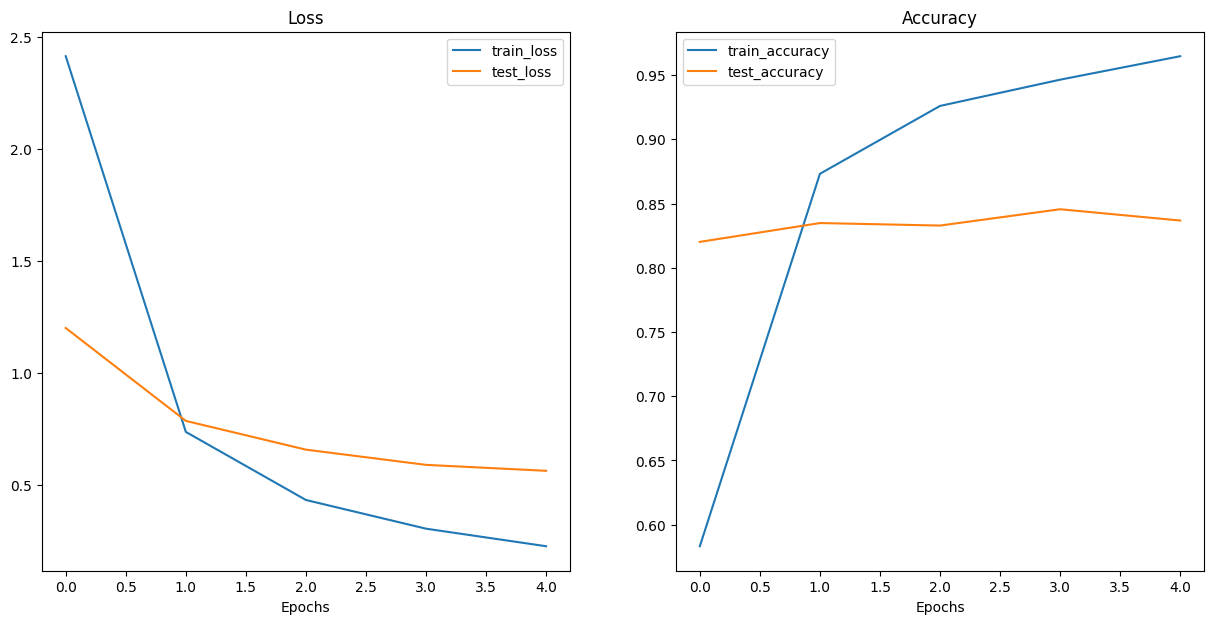

In [ ]:
plot_loss_curves(results_restnet50)

Let's try to train the model again unfreezing the last two layers instead of only the classifier

In [ ]:
# Reinsate the model
model_res50 = torchvision.models.resnet50(weights=weights)

In [ ]:
# Freeze all layers
for param in model_res50.parameters():
    param.requires_grad = False

# Change the classifier
model_res50.fc = nn.Linear(in_features=2048, out_features=len(class_names))

# Unfreeze last two blocks + classifier
for param in model_res50.layer3.parameters():
    param.requires_grad = True
for param in model_res50.layer4.parameters():
    param.requires_grad = True
for param in model_res50.fc.parameters():
    param.requires_grad = True


In [ ]:
# Use a smaller LR
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model_res50.parameters()), lr=1e-4)
loss_fn = nn.CrossEntropyLoss()

In [ ]:
# Set random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

model_res50 = model_res50.to(device)

EPOCHS = 5

# Set up training
results_restnet50_1 = train(model=model_res50,
                          train_dataloader = train_dataloader,
                          test_dataloader = val_dataloader,
                          optimizer = optimizer,
                          loss_fn = loss_fn,
                          epochs = EPOCHS,
                          device = device)

Training Epochs:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1/5 — Train Loss: 2.3443, Train Acc: 0.5401 | Test Loss: 0.7325, Test Acc: 0.8055
Epoch 2/5 — Train Loss: 0.5404, Train Acc: 0.8621 | Test Loss: 0.5811, Test Acc: 0.8231
Epoch 3/5 — Train Loss: 0.2300, Train Acc: 0.9437 | Test Loss: 0.5382, Test Acc: 0.8358
Epoch 4/5 — Train Loss: 0.1208, Train Acc: 0.9713 | Test Loss: 0.6198, Test Acc: 0.8250
Epoch 5/5 — Train Loss: 0.0720, Train Acc: 0.9838 | Test Loss: 0.6332, Test Acc: 0.8270


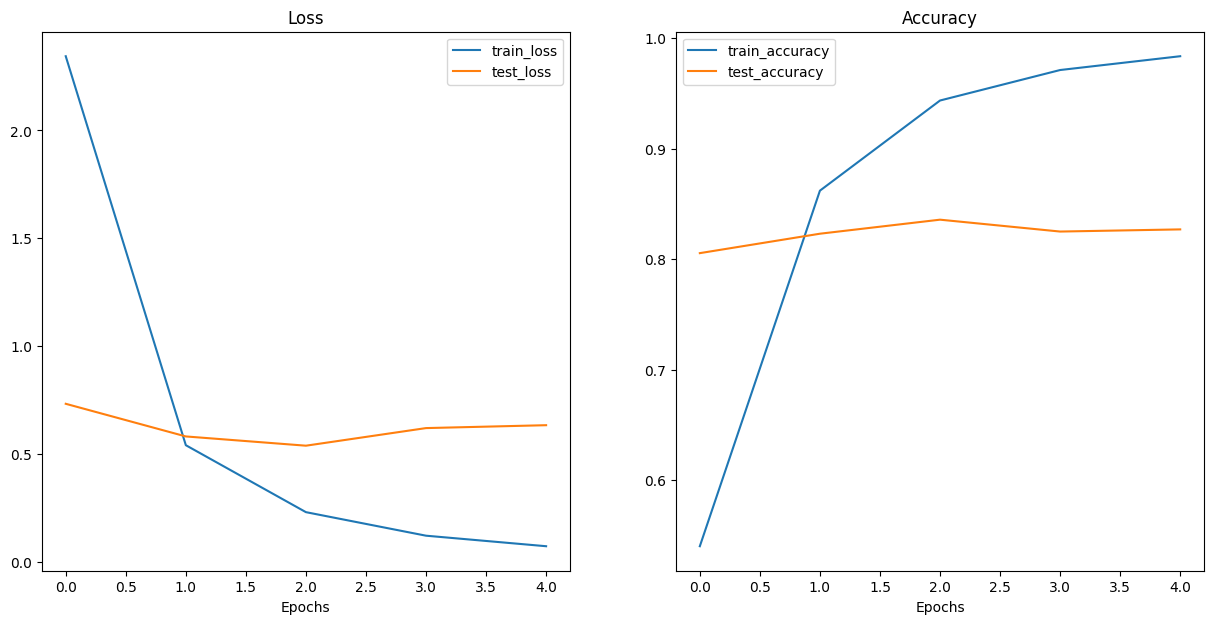

In [ ]:
plot_loss_curves(results_restnet50_1)

In [63]:
def plot_loss_curves(results):
    """Plots training curves of a results dictionary.

    Args:
        results (dict): dictionary containing list of values, e.g.
            {"train_loss": [...],
             "train_acc": [...],
             "val_loss": [...],
             "val_acc": [...]}
    """
    loss = results["train_loss"]
    val_loss = results["val_loss"]

    accuracy = results["train_acc"]
    val_accuracy = results["val_acc"]

    epochs = range(len(results["train_loss"]))

    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label="train_loss")
    plt.plot(epochs, val_loss, label="val_loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label="train_accuracy")
    plt.plot(epochs, val_accuracy, label="val_accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.legend()




As we can see our model is overfitting. We are going to try to use data agumentation to see if we can improve our results.

First we are going to retrain our model with only the classifier unfreeze.

In [ ]:
# Create transforms with data augmantion
from torchvision import transforms

train_transforms_aug = transforms.Compose([
    transforms.RandomResizedCrop(224),      # Randomly crop and resize to 224x224 (standard for ResNet)
    transforms.RandomHorizontalFlip(),      # Flip images left-right, because why not
    transforms.RandomRotation(15),           # Slight rotation for that “I’m not perfect” vibe
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Mess with colors a bit
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])


In [ ]:
# Create datasets
train_dataset_aug = DogVisionDataset(dataframe=train_df,
                                 img_dir = train_dir,
                                 transform = train_transforms_aug)

val_dataset = DogVisionDataset(dataframe = val_df,
                               img_dir = train_dir,
                               transform = val_transforms)

In [ ]:
# Create DataLoaders
from torch.utils.data import DataLoader
BATCH_SIZE = 32
NUM_WORKERS = 2

train_dataloader_aug = DataLoader(train_dataset_aug,
                              batch_size = BATCH_SIZE,
                              shuffle = True,
                              num_workers = NUM_WORKERS)

val_dataloader = DataLoader(val_dataset,
                            batch_size = BATCH_SIZE,
                            shuffle = False,
                            num_workers = NUM_WORKERS)

In [ ]:
# Setup model with pretrained weights
weights = torchvision.models.ResNet50_Weights.DEFAULT
model_res50 = torchvision.models.resnet50(weights=weights)

In [ ]:
# Freeze all base layers
for param in model_res50.parameters():
  param.requires_grad = False

#model_res50.fc.requires_grad_(True)

# Change the classifier
model_res50.fc = nn.Linear(in_features=2048, out_features=len(class_names))
model_res50.fc.requires_grad_(True)

Linear(in_features=2048, out_features=120, bias=True)

In [ ]:
# Define loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model_res50.parameters()), lr=0.001)


In [ ]:
# Set random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

model_res50 = model_res50.to(device)

EPOCHS = 5

# Set up training
results_restnet50_2 = train(model=model_res50,
                          train_dataloader = train_dataloader_aug,
                          test_dataloader = val_dataloader,
                          optimizer = optimizer,
                          loss_fn = loss_fn,
                          epochs = EPOCHS,
                          device = device)

Training Epochs:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1/5 — Train Loss: 3.0916, Train Acc: 0.4162 | Test Loss: 1.5007, Test Acc: 0.8025
Epoch 2/5 — Train Loss: 1.7551, Train Acc: 0.6259 | Test Loss: 0.8818, Test Acc: 0.8358
Epoch 3/5 — Train Loss: 1.3953, Train Acc: 0.6719 | Test Loss: 0.6663, Test Acc: 0.8504
Epoch 4/5 — Train Loss: 1.2605, Train Acc: 0.6888 | Test Loss: 0.5762, Test Acc: 0.8465
Epoch 5/5 — Train Loss: 1.1822, Train Acc: 0.7044 | Test Loss: 0.5154, Test Acc: 0.8661


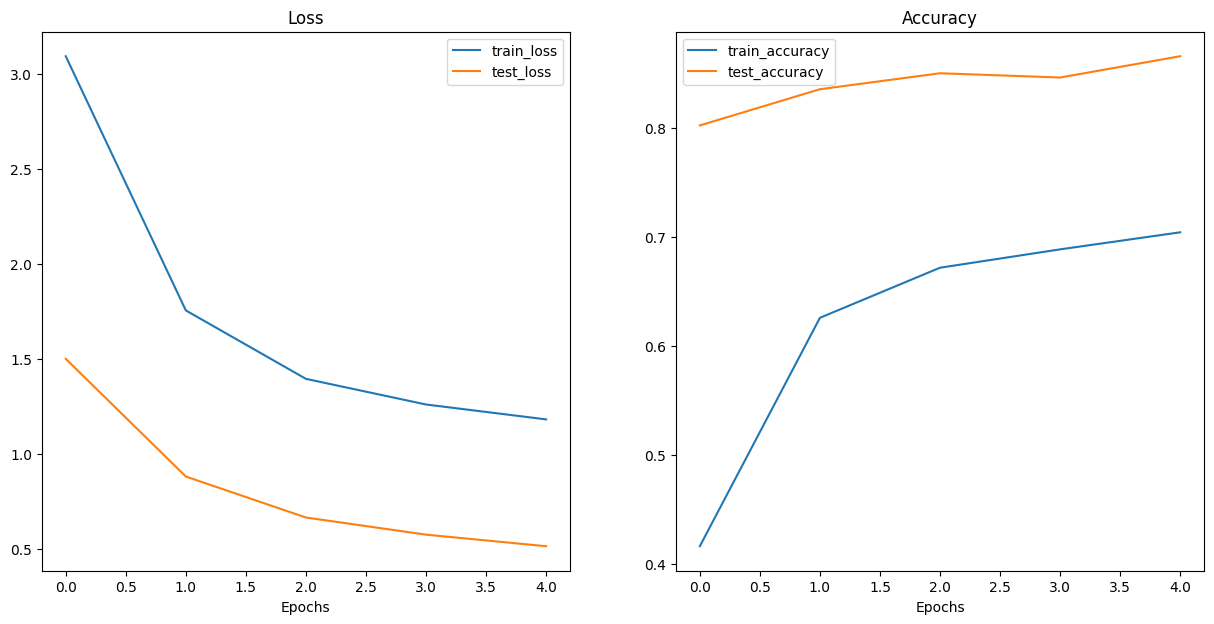

In [ ]:
plot_loss_curves(results_restnet50_2)

Le'ts try again with unfreezeing some more layers.

In [ ]:
# Reinsate the model
model_res50 = torchvision.models.resnet50(weights=weights)

In [ ]:
# Freeze all layers
for param in model_res50.parameters():
    param.requires_grad = False

# Change the classifier
model_res50.fc = nn.Linear(in_features=2048, out_features=len(class_names))

# Unfreeze last two blocks + classifier
for param in model_res50.layer3.parameters():
    param.requires_grad = True
for param in model_res50.layer4.parameters():
    param.requires_grad = True
for param in model_res50.fc.parameters():
    param.requires_grad = True


In [ ]:
# Use a smaller LR
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model_res50.parameters()), lr=1e-4)
loss_fn = nn.CrossEntropyLoss()

In [ ]:
# Set random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

model_res50 = model_res50.to(device)

EPOCHS = 5

# Set up training
results_restnet50_3 = train(model=model_res50,
                          train_dataloader = train_dataloader_aug,
                          test_dataloader = val_dataloader,
                          optimizer = optimizer,
                          loss_fn = loss_fn,
                          epochs = EPOCHS,
                          device = device)

Training Epochs:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1/5 — Train Loss: 3.0127, Train Acc: 0.3809 | Test Loss: 0.8424, Test Acc: 0.7879
Epoch 2/5 — Train Loss: 1.4807, Train Acc: 0.6201 | Test Loss: 0.6254, Test Acc: 0.8162
Epoch 3/5 — Train Loss: 1.2050, Train Acc: 0.6814 | Test Loss: 0.5614, Test Acc: 0.8192
Epoch 4/5 — Train Loss: 1.1184, Train Acc: 0.7023 | Test Loss: 0.5666, Test Acc: 0.8397
Epoch 5/5 — Train Loss: 1.0443, Train Acc: 0.7166 | Test Loss: 0.5582, Test Acc: 0.8182


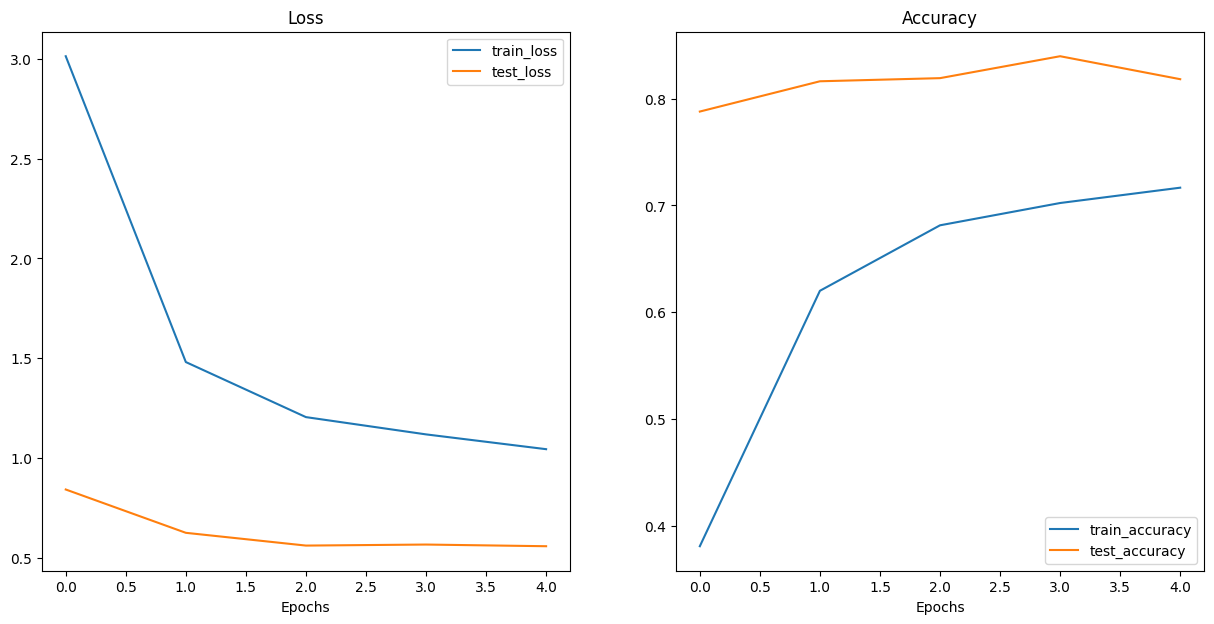

In [ ]:
plot_loss_curves(results_restnet50_2)

### 2.2. Trying MobileNetV3

In [27]:
# Create dataset
class DogVisionDataset(Dataset):
  """
  Arguments:
    dataframe (pd.DataFrame): DataFrame with image IDs and labels
    img_dir(str): directory to the images
    transform (callable, optional): Optional transform to be applied on a sample.
  """
  def __init__(self, dataframe:pd.DataFrame,
               img_dir: str,
               transform = None):
    self.dataframe = dataframe
    self.img_dir = img_dir
    self.transform = transform

  def __len__(self):
    return len(self.dataframe)

  def __getitem__(self, idx):
    if torch.is_tensor(idx):
        idx = idx.tolist()

    img_path = os.path.join(self.img_dir, self.dataframe.iloc[idx,0] + ".jpg")
    img = Image.open(img_path).convert("RGB")

    label = self.dataframe.iloc[idx,2]
    label = torch.tensor(label).long()

    if self.transform:
        img = self.transform(img)


    return img, label

In [41]:
# Compile weights and model
weights = torchvision.models.MobileNet_V2_Weights.DEFAULT
model_mob = torchvision.models.mobilenet_v2(weights = weights)

In [42]:
# Create transforms with data augmenantion
from torchvision import transforms

train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),          # Randomly crop and resize to 224x224 — classic move
    transforms.RandomHorizontalFlip(p=0.5),     # Flip that pup left to right half the time
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Spice up colors a bit
    transforms.RandomRotation(degrees=15),      # Tilt your pups slightly to confuse the model
    transforms.ToTensor(),                       # Convert PIL image to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  # Normalize like ImageNet pros
                         std=[0.229, 0.224, 0.225]),
])

val_transforms = transforms.Compose([
    transforms.Resize(256),                      # Resize so we keep aspect ratio
    transforms.CenterCrop(224),                  # Then center crop to 224x224
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

In [43]:
# Create datasets
train_dataset = DogVisionDataset(dataframe=train_df,
                                 img_dir = train_dir,
                                 transform = train_transforms)

val_dataset = DogVisionDataset(dataframe = val_df,
                               img_dir = train_dir,
                               transform = val_transforms)

In [44]:
# Create DataLoaders
from torch.utils.data import DataLoader
BATCH_SIZE = 32
NUM_WORKERS = 2

train_dataloader= DataLoader(train_dataset,
                              batch_size = BATCH_SIZE,
                              shuffle = True,
                              num_workers = NUM_WORKERS)

val_dataloader = DataLoader(val_dataset,
                            batch_size = BATCH_SIZE,
                            shuffle = False,
                            num_workers = NUM_WORKERS)

In [45]:
#  Get a summary of our model
from torchinfo import summary

summary(model=model_mob,
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape"
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                       Input Shape          Output Shape         Param #              Trainable
MobileNetV2 (MobileNetV2)                     [32, 3, 224, 224]    [32, 1000]           --                   True
├─Sequential (features)                       [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   True
│    └─Conv2dNormActivation (0)               [32, 3, 224, 224]    [32, 32, 112, 112]   --                   True
│    │    └─Conv2d (0)                        [32, 3, 224, 224]    [32, 32, 112, 112]   864                  True
│    │    └─BatchNorm2d (1)                   [32, 32, 112, 112]   [32, 32, 112, 112]   64                   True
│    │    └─ReLU6 (2)                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─InvertedResidual (1)                   [32, 32, 112, 112]   [32, 16, 112, 112]   --                   True
│    │    └─Sequential (conv)                 [32, 32, 112, 112]   [32, 16, 112, 112]

In [46]:
# Freeze all base layers
for param in model_mob.parameters():
  param.requires_grad = False

#model_mob.classifier.requires_grad_(True)

# Change the classifier
model_mob.classifier[1] = nn.Linear(in_features=1280, out_features=len(class_names))
model_mob.classifier.requires_grad_(True)

Sequential(
  (0): Dropout(p=0.2, inplace=False)
  (1): Linear(in_features=1280, out_features=120, bias=True)
)

In [47]:
# Do a summary *after* freezing the features and changing the output classifier layer
summary(model_mob,
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape" (batch_size, color_channels, height, width)
        verbose=0,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                       Input Shape          Output Shape         Param #              Trainable
MobileNetV2 (MobileNetV2)                     [32, 3, 224, 224]    [32, 120]            --                   Partial
├─Sequential (features)                       [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)               [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                        [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                   [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─ReLU6 (2)                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─InvertedResidual (1)                   [32, 32, 112, 112]   [32, 16, 112, 112]   --                   False
│    │    └─Sequential (conv)                 [32, 32, 112, 112]   [32, 16, 1

In [48]:
# Define loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model_mob.parameters()), lr=0.001)


In [49]:
# Set random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

model_mob = model_mob.to(device)

EPOCHS = 10

# Set up training
results_mob = train(model=model_mob,
                    train_dataloader = train_dataloader,
                    test_dataloader = val_dataloader,
                    optimizer = optimizer,
                    loss_fn = loss_fn,
                    epochs = EPOCHS,
                    device = device)

Training Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10 — Train Loss: 3.6608, Train Acc: 0.2359 | Test Loss: 2.2890, Test Acc: 0.5579
Epoch 2/10 — Train Loss: 2.5546, Train Acc: 0.4301 | Test Loss: 1.6331, Test Acc: 0.6240
Epoch 3/10 — Train Loss: 2.2157, Train Acc: 0.4787 | Test Loss: 1.3995, Test Acc: 0.6621
Epoch 4/10 — Train Loss: 2.0400, Train Acc: 0.5062 | Test Loss: 1.2858, Test Acc: 0.6699
Epoch 5/10 — Train Loss: 1.9228, Train Acc: 0.5254 | Test Loss: 1.2023, Test Acc: 0.6709
Epoch 6/10 — Train Loss: 1.8644, Train Acc: 0.5298 | Test Loss: 1.1400, Test Acc: 0.6919
Epoch 7/10 — Train Loss: 1.8421, Train Acc: 0.5321 | Test Loss: 1.1474, Test Acc: 0.6841
Epoch 8/10 — Train Loss: 1.7938, Train Acc: 0.5489 | Test Loss: 1.0604, Test Acc: 0.7046
Epoch 9/10 — Train Loss: 1.7185, Train Acc: 0.5577 | Test Loss: 1.0943, Test Acc: 0.6875
Epoch 10/10 — Train Loss: 1.7021, Train Acc: 0.5634 | Test Loss: 1.0209, Test Acc: 0.7086


In [ ]:
plot_loss_curves(results_mob)

## Try a ViT model

In [66]:
# Compile weights and model
weights = torchvision.models.ViT_B_16_Weights.DEFAULT
model_vit = torchvision.models.vit_b_16(weights = weights)

In [67]:
# Create transforms
from torchvision import transforms
from torchvision.transforms import InterpolationMode

train_transforms_vit = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomResizedCrop(224, scale=(0.9, 1.0), interpolation=InterpolationMode.BILINEAR),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])


val_transforms_vit = transforms.Compose([
    transforms.Resize(256, interpolation=InterpolationMode.BILINEAR),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])


In [68]:
# Create datasets
train_dataset = DogVisionDataset(dataframe=train_df,
                                 img_dir = train_dir,
                                 transform = train_transforms_vit)

val_dataset = DogVisionDataset(dataframe=val_df,
                               img_dir = train_dir,
                               transform = val_transforms_vit)

In [69]:
# Create dataloaders
BATCH_SIZE = 32
NUM_WORKERS = 2

train_dataloader = DataLoader(dataset= train_dataset,
                              batch_size = BATCH_SIZE,
                              shuffle = True,
                              num_workers = NUM_WORKERS)

val_dataloader = DataLoader(dataset=val_dataset,
                         batch_size = BATCH_SIZE,
                         shuffle=  False,
                         num_workers = NUM_WORKERS)

In [70]:
#  Get a summary of our model
from torchinfo import summary

summary(model=model_vit,
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape"
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [32, 3, 224, 224]    [32, 1000]           768                  True
├─Conv2d (conv_proj)                                         [32, 3, 224, 224]    [32, 768, 14, 14]    590,592              True
├─Encoder (encoder)                                          [32, 197, 768]       [32, 197, 768]       151,296              True
│    └─Dropout (dropout)                                     [32, 197, 768]       [32, 197, 768]       --                   --
│    └─Sequential (layers)                                   [32, 197, 768]       [32, 197, 768]       --                   True
│    │    └─EncoderBlock (encoder_layer_0)                   [32, 197, 768]       [32, 197, 768]       7,087,872            True
│    │    └─EncoderBlock (encoder_layer_1)                   [32, 197, 768]       [32, 197, 76

In [71]:
# Freeze all base layers
for param in model_vit.parameters():
  param.requires_grad = False

#model_vit.heads.requires_grad_(True)

# Change the classifier
model_vit.heads = nn.Linear(in_features=768, out_features=len(class_names))
model_vit.heads.requires_grad_(True)

Linear(in_features=768, out_features=120, bias=True)

In [73]:
# Define loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_vit.parameters(),
                            lr = 0.005,
                            momentum=0.9)

In [74]:
# Set random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

model_vit = model_vit.to(device)

EPOCHS = 5

# Set up training
results_vit = train(model=model_vit,
                    train_dataloader = train_dataloader,
                    val_dataloader = val_dataloader,
                    optimizer = optimizer,
                    loss_fn = loss_fn,
                    epochs = EPOCHS,
                    device = device)

Training Epochs:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1/5 — Train Loss: 1.4977, Train Acc: 0.8107 | Val Loss: 0.3157, Val Acc: 0.9403
Epoch 2/5 — Train Loss: 0.2620, Train Acc: 0.9469 | Val Loss: 0.2193, Val Acc: 0.9418
Epoch 3/5 — Train Loss: 0.2008, Train Acc: 0.9532 | Val Loss: 0.1946, Val Acc: 0.9438
Epoch 4/5 — Train Loss: 0.1675, Train Acc: 0.9574 | Val Loss: 0.1837, Val Acc: 0.9477
Epoch 5/5 — Train Loss: 0.1489, Train Acc: 0.9617 | Val Loss: 0.1765, Val Acc: 0.9472


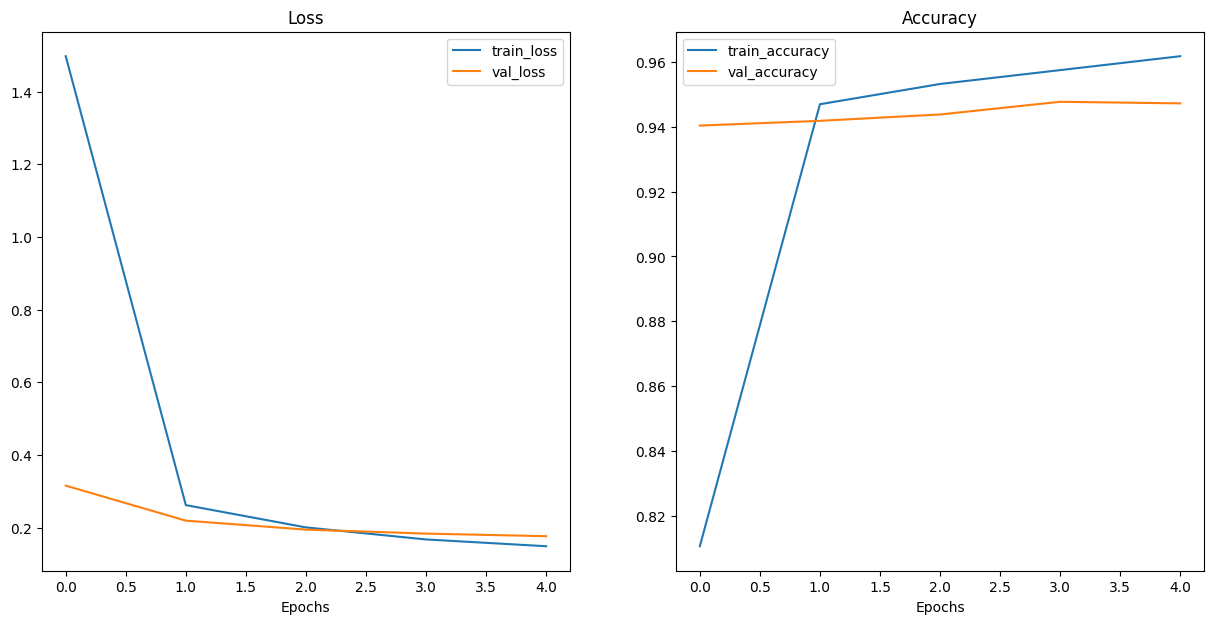

In [75]:
plot_loss_curves(results_vit)

In [91]:
torch.save(model_vit.state_dict(), "vit_dog_breed.pth")

## Turn Dog Vision into a deployable app

In [92]:
def predict_image(image: Image.Image) -> str:
    model_vit.eval()

    # Apply the same transform as validation
    transformed = val_transforms_vit(image).unsqueeze(0).to(device)

    with torch.no_grad():
        outputs = model_vit(transformed)
        probs = torch.softmax(outputs, dim=1)
        pred_index = probs.argmax(dim=1).item()
        pred_class = class_names[pred_index]
        confidence = probs[0][pred_index].item()

    return f"{pred_class} ({confidence*100:.2f}%)"


In [93]:
import gradio as gr
from PIL import Image

iface = gr.Interface(
    fn=predict_image,
    inputs=gr.Image(type="pil"),
    outputs="text",
    title="🐶 Dog Breed Classifier (ViT)",
    description="Upload a picture of a dog and get the predicted breed!"
)

iface.launch()


It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://0336416538c5af6c1e.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [79]:
import shutil
from pathlib import Path

# Create  Dog Vision demo path
dog_vision_demo_path = Path("demos/dog_vision/")

# Remove files that might already exist there and create new directory
if dog_vision_demo_path.exists():
    shutil.rmtree(dog_vision_demo_path)
# If the file doesn't exist, create it anyway
dog_vision_demo_path.mkdir(parents=True,
                                exist_ok=True)

In [95]:
# Create path to DogVision class names
dog_vision_class_names_path = dog_vision_demo_path / "class_names.txt"

# Write DogVision class names list to file
with open (dog_vision_class_names_path, "w") as f:
  print(f"[INFO] Saving Dog Vision class names to {dog_vision_class_names_path}")
  f.write('\n'.join(class_names))

[INFO] Saving Dog Vision class names to demos/dog_vision/class_names.txt


In [ ]:
%%writefile demos/dog_vision/mdel.py
import torch
import torchvision

from torch import nn

def create_vit_model(num_class: int=120,
                     seed: int = 42):
  """ Create a ViT_B_16 features extractor

In [96]:
%%writefile demos/dog_vision/app.py
### 1. Imports and class names setup ###
import gradio as gr
import os
import torch
import torchvision

from torchvision import transforms
from torchvision.transforms import InterpolationMode

from timeit import default_timer as timer
from typing import Tuple, Dict


# Setup class names
with open("class_names.txt", "r") as f:
  class_names = [line.strip() for line in f.readlines()]

### 2. Model and transforms preparation ###

## Create the model##
# Compile weights and model
weights = torchvision.models.ViT_B_16_Weights.DEFAULT
model_vit = torchvision.models.vit_b_16(weights = weights)
model_vit.heads = torch.nn.Linear(in_features=768, out_features=len(class_names))
model_vit = model_vit.to("cpu")

# Create transforms
val_transforms_vit = transforms.Compose([
    transforms.Resize(256, interpolation=InterpolationMode.BILINEAR),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

## Load saved weights
model_vit.load_state_dict(
    torch.load(
        f = "vit_dog_breed.pth",
        map_location = torch.device("cpu") # load model to CPU
    )
)

### 3. Predict function ###
def predict(img) -> Tuple[Dict, float]:
  """ Transforms and performs a prediction on a image and return
  predictin and time taken.
  """
  # Start timer
  start_time = timer()

  # Transform the target image and add a batch dimension
  img = val_transforms_vit(img).unsqueeze(0)

  # Put model into evaluation mode and turn on inferece mode
  model_vit.eval()
  with torch.inference_mode():
    # Pass the transformed image through the model and turn the prediction logits into prediction probabilities
    pred_probs = torch.softmax(model_vit(img), dim = 1)

  # Create a prediction label and prediction probability dictionary for each prediction class (this is the required format for Gradio's output parameter)
  pred_labels_and_probs = {class_names[i]: float(pred_probs[0][i]) for i in range(len(class_names))}

  # Calculate the prediction time
  pred_time = round(timer() - start_time, 4)

  # Return the prediction dictionary and prediction time
  return pred_labels_and_probs, pred_time


### 4. Gradio app ###
# Create title, description and article strings
title = "Dog breed classification 🐕🐶"
description = "A ViT model to classify images of dogs into [120 different classes](https://www.kaggle.com/c/dog-breed-identification/data)"

# Create Gradio interface
demo = gr.Interface(
    fn=predict,
    inputs=gr.Image(type="pil"),
    outputs=[
        gr.Label(num_top_classes=3, label="Predictions"),
        gr.Number(label="Prediction time (s)"),
    ],
    examples = None,
    title=title,
    description=description,
)

# Launch the app!
demo.launch()

Writing demos/dog_vision/app.py


In [97]:
torch.__version__

'2.6.0+cu124'

In [99]:
torchvision.__version__

'0.21.0+cu124'

In [103]:
%%writefile demos/dog_vision/requirements.txt
torch == 2.6.0
torchvision == 0.21.0
gradio == 5.33.
Pillow

Overwriting demos/dog_vision/requirements.txt


In [104]:
# Zip dog_vision folder but exclude certain files
!cd demos/dog_vision && zip -r ../dog_vision.zip * -x "*.pyc" "*.ipynb" "*__pycache__*" "*ipynb_checkpoints*"

# Download the zipped Dog Vision app (if running in Google Colab)
try:
    from google.colab import files
    files.download("demos/dog_vision.zip")
except:
    print("Not running in Google Colab, can't use google.colab.files.download()")

  adding: app.py (deflated 55%)
  adding: class_names.txt (deflated 54%)
  adding: requirements.txt (deflated 10%)
  adding: vit_dog_breed.pth (deflated 7%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>